In [1]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
import pandas as pd
import numpy as np


In [3]:
import numpy as np

def load_dataset(datasetPath):

  # List for storing data
  data = []
  
  # List for storing labels
  labels = []
  
  for row in open(datasetPath): #Openfile and start reading each row
    #Split the row at every comma
    row = row.split(",")
    
    #row[0] contains label
    label = int(row[0])
    
    #Other all collumns contains pixel values make a saperate array for that
    image = np.array([int(x) for x in row[1:]], dtype="uint8")
    
    #Reshaping image to 28 x 28 pixels
    image = image.reshape((32, 32))
    
    #append image to data
    data.append(image)
    
    #append label to labels
    labels.append(label)
    
  #Converting data to numpy array of type float32
  data = np.array(data, dtype='float32')
  
  #Converting labels to type int
  labels = np.array(labels, dtype="int")
  
  return (data, labels)

In [20]:
(Data, Labels) = load_dataset("../data/uaset_without_columns.csv")


In [6]:
(Data, Labels) = load_dataset("../data/uaset_extended_lower_case_size_reduction.csv")

In [7]:
import cv2

# Each image in the A-Z and MNIST digts datasets are 28x28 pixels;
# However, the architecture we're using is designed for 32x32 images,
# So we need to resize them to 32x32

Data = [cv2.resize(image, (32, 32)) for image in Data]
Data = np.array(Data, dtype="float32")

# add a channel dimension to every image in the dataset and scale the
# pixel intensities of the images from [0, 255] down to [0, 1]

Data = np.expand_dims(Data, axis=-1)
Data /= 255.0

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

le = LabelBinarizer()
Labels = le.fit_transform(Labels)

counts = Labels.sum(axis=0)

# account for skew in the labeled data
classTotals = Labels.sum(axis=0)
classWeight = {}

# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
  classWeight[i] = classTotals.max() / classTotals[i]
  
(trainX, testX, trainY, testY) = train_test_split(Data,
	Labels, test_size=0.30, stratify=Labels, random_state=42)

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# construct the image generator for data augmentation

aug = ImageDataGenerator(
rotation_range=5,
zoom_range=0.05,
width_shift_range=0.10,
height_shift_range=0.10,
shear_range=0.1,
horizontal_flip=False,
fill_mode="nearest")

In [10]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import add
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

class ResNet:
	@staticmethod
	def residual_module(data, K, stride, chanDim, red=False,
		reg=0.0001, bnEps=2e-5, bnMom=0.9):
		# the shortcut branch of the ResNet module should be
		# initialize as the input (identity) data
		shortcut = data

		# the first block of the ResNet module are the 1x1 CONVs
		bn1 = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(data)
		act1 = Activation("relu")(bn1)
		conv1 = Conv2D(int(K * 0.25), (1, 1), use_bias=False,
			kernel_regularizer=l2(reg))(act1)

		# the second block of the ResNet module are the 3x3 CONVs
		bn2 = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(conv1)
		act2 = Activation("relu")(bn2)
		conv2 = Conv2D(int(K * 0.25), (3, 3), strides=stride,
			padding="same", use_bias=False,
			kernel_regularizer=l2(reg))(act2)

		# the third block of the ResNet module is another set of 1x1
		# CONVs
		bn3 = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(conv2)
		act3 = Activation("relu")(bn3)
		conv3 = Conv2D(K, (1, 1), use_bias=False,
			kernel_regularizer=l2(reg))(act3)

		# if we are to reduce the spatial size, apply a CONV layer to
		# the shortcut
		if red:
			shortcut = Conv2D(K, (1, 1), strides=stride,
				use_bias=False, kernel_regularizer=l2(reg))(act1)

		# add together the shortcut and the final CONV
		x = add([conv3, shortcut])

		# return the addition as the output of the ResNet module
		return x

	@staticmethod
	def build(width, height, depth, classes, stages, filters,
		reg=0.0001, bnEps=2e-5, bnMom=0.9, dataset="cifar"):
		# initialize the input shape to be "channels last" and the
		# channels dimension itself
		inputShape = (height, width, depth)
		chanDim = -1

		# if we are using "channels first", update the input shape
		# and channels dimension
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1

		# set the input and apply BN
		inputs = Input(shape=inputShape)
		x = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(inputs)

		# check if we are utilizing the CIFAR dataset
		if dataset == "cifar":
			# apply a single CONV layer
			x = Conv2D(filters[0], (3, 3), use_bias=False,
				padding="same", kernel_regularizer=l2(reg))(x)

		# check to see if we are using the Tiny ImageNet dataset
		elif dataset == "tiny_imagenet":
			# apply CONV => BN => ACT => POOL to reduce spatial size
			x = Conv2D(filters[0], (5, 5), use_bias=False,
				padding="same", kernel_regularizer=l2(reg))(x)
			x = BatchNormalization(axis=chanDim, epsilon=bnEps,
				momentum=bnMom)(x)
			x = Activation("relu")(x)
			x = ZeroPadding2D((1, 1))(x)
			x = MaxPooling2D((3, 3), strides=(2, 2))(x)

		# loop over the number of stages
		for i in range(0, len(stages)):
			# initialize the stride, then apply a residual module
			# used to reduce the spatial size of the input volume
			stride = (1, 1) if i == 0 else (2, 2)
			x = ResNet.residual_module(x, filters[i + 1], stride,
				chanDim, red=True, bnEps=bnEps, bnMom=bnMom)

			# loop over the number of layers in the stage
			for j in range(0, stages[i] - 1):
				# apply a ResNet module
				x = ResNet.residual_module(x, filters[i + 1],
					(1, 1), chanDim, bnEps=bnEps, bnMom=bnMom)

		# apply BN => ACT => POOL
		x = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(x)
		x = Activation("relu")(x)
		x = AveragePooling2D((8, 8))(x)

		# softmax classifier
		x = Flatten()(x)
		x = Dense(classes, kernel_regularizer=l2(reg))(x)
		x = Activation("softmax")(x)

		# create the model
		model = Model(inputs, x, name="resnet")

		# return the constructed network architecture
		return model

In [11]:
EPOCHS = 120
INIT_LR = 1
BS = 64

In [12]:
from tensorflow.keras.optimizers import SGD

print("[INFO] compiling model...")
opt = SGD(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model = ResNet.build(32, 32, 1, len(le.classes_), (3, 3, 3),
	(64, 64, 128, 256), reg=0.0005)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [13]:
model.summary()

Model: "resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 1)    4           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   576         batch_normalization[0][0]        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 64)   256         conv2d[0][0]                     
_____________________________________________________________________________________________

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Додайте колбеки
early_stopping = EarlyStopping(monitor='val_loss', patience=12, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.001, verbose=1)

callbacks_list = [early_stopping, reduce_lr]

In [15]:
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(testX, testY),
    steps_per_epoch=len(trainX) // BS,
    epochs=EPOCHS,
    class_weight=classWeight,
    callbacks=callbacks_list,
    verbose=1
)

Epoch 1/120
149/149 [==============================] - 14s 95ms/step - loss: 4.4664 - accuracy: 0.1380 - val_loss: 2.6692 - val_accuracy: 0.2526 - lr: 1.0000
Epoch 2/120
149/149 [==============================] - 13s 84ms/step - loss: 2.1305 - accuracy: 0.5986 - val_loss: 1.7585 - val_accuracy: 0.5753 - lr: 1.0000
Epoch 3/120
149/149 [==============================] - 13s 85ms/step - loss: 1.2800 - accuracy: 0.7902 - val_loss: 0.8215 - val_accuracy: 0.8631 - lr: 1.0000
Epoch 4/120
149/149 [==============================] - 13s 85ms/step - loss: 1.0525 - accuracy: 0.8409 - val_loss: 0.8530 - val_accuracy: 0.8433 - lr: 1.0000
Epoch 5/120
149/149 [==============================] - 13s 85ms/step - loss: 0.9337 - accuracy: 0.8659 - val_loss: 0.7253 - val_accuracy: 0.8782 - lr: 1.0000
Epoch 6/120
149/149 [==============================] - 13s 85ms/step - loss: 0.8495 - accuracy: 0.8841 - val_loss: 0.6532 - val_accuracy: 0.8978 - lr: 1.0000
Epoch 7/120
149/149 [==============================]

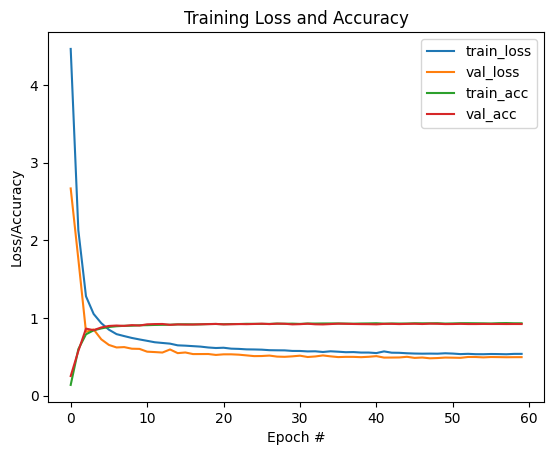

In [16]:
import matplotlib.pyplot as plt

# Графіки тренування моделі
plt.figure()
plt.plot(H.history['loss'], label='train_loss')
plt.plot(H.history['val_loss'], label='val_loss')
plt.plot(H.history['accuracy'], label='train_acc')
plt.plot(H.history['val_accuracy'], label='val_acc')
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend(loc='upper right')
plt.show()

In [17]:
model.save('Ukrainian_OCR_tf_2.1_lower_case.h5',save_format=".h5")

In [8]:
import tensorflow as tf

model = tf.keras.models.load_model('Ukrainian_OCR_tf_2.1_corrected_lower_case.h5')

In [18]:
from sklearn.metrics import classification_report

# define the list of label names

labelNames = "абвгґдеєжзиіїйклмнопрстуфхцчшщьюя1234567890№%@,.?:;\"!()-'"
labelNames = [l for l in labelNames]
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=BS)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=labelNames))

[INFO] evaluating network...
              precision    recall  f1-score   support

           а       0.99      0.93      0.96        92
           б       1.00      0.97      0.98        91
           в       0.99      1.00      0.99        91
           г       0.99      0.99      0.99        91
           ґ       0.97      0.99      0.98        91
           д       0.98      0.96      0.97        91
           е       0.97      0.97      0.97        91
           є       1.00      0.97      0.98        91
           ж       1.00      1.00      1.00        91
           з       0.85      0.84      0.84        91
           и       0.84      0.97      0.90        91
           і       0.72      0.89      0.80        91
           ї       0.87      0.67      0.76        92
           й       1.00      0.79      0.88        91
           к       1.00      0.98      0.99        90
           л       0.98      1.00      0.99        91
           м       0.97      1.00      0.98        9

In [10]:
output = ""

In [11]:
from imutils import build_montages
from PIL import Image, ImageDraw, ImageFont
import numpy as np

images = []
# randomly select a few testing characters

for i in np.random.choice(np.arange(0, len(testY)), size=(66,)):
    probs = model.predict(testX[np.newaxis, i])
    prediction = probs.argmax(axis=1)
    label = labelNames[prediction[0]]
    output += label
    image = (testX[i] * 255).astype("uint8")
    color = (0, 255, 0)
    color = (0, 0, 255)
    image = cv2.merge([image] * 3)
    image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
    img_pil = Image.fromarray(image)
    draw = ImageDraw.Draw(img_pil)
    font = ImageFont.truetype("arial.ttf", size=34)
    draw.text((5, 20), label, font=font, fill=color)
    image = np.array(img_pil)
    images.append(image)
  
montage = build_montages(images, (96, 96), (7, 7))[0]
cv2.imshow('q',montage)
cv2.waitKey(0)
cv2.destroyAllWindows()

'гЛЄРНезцХВЙжЮЕйткЗПццЗнТчХЧСрОРаФЬЩҐтИЖйИАОтЯмрЛЩ'